### run a QTL analysis with the PCs of coexpression clusters as the dependent variable
try with pc_1 as a test case

done via script: 
* step 1. Get PCs
* step 2. Run QTLs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.decomposition import PCA
import os
import tensorqtl
from tensorqtl import pgen, cis, trans, post, genotypeio

from upsetplot import from_memberships,  plot

#### Get PCs

There are many different ways one could theoretically combine PCs - for a second pass I'll look at the other pcs, but still just individually 


Start with Fibroblasts and all chrs

In [8]:
#tissue_id = 'Whole_Blood'
chr_id = '21'
pc_id = 1
tissue_id = 'Whole_Blood'
pc_out_prefix=f'/home/klawren/oak/coexp_eqtl/output/3_eqtl_pcs/{tissue_id}_old/{tissue_id}'
e_out_prefix=f'/home/klawren/oak/coexp_eqtl/output/2_eqtl_control/{tissue_id}_old/{tissue_id}'


In [272]:
# load in cluster data
cluster_path = f'/home/klawren/oak/coexp_eqtl/tami_eqtl_proejct/output/1_correlations/{tissue_id}/clusters_chr_{chr_id}.csv'
cluster_df = pd.read_csv(cluster_path)
cluster_orig_columns = cluster_df.columns.values
cluster_df.head()

,N_genes,Transcripts,Genes,Perc_cor,Mean_cor,Mean_pos_cor,Mean_neg_cor,Chromosome,Tissue
0,5,"ENSG00000160256.12,ENSG00000276529.1,ENSG00000...","FAM207A, ADARB1, LINC00163, SSR4P1, AP001505.10",80.000,0.371,0.371,NaN,21,Cells_Cultured_fibroblasts
1,4,"ENSG00000160255.17,ENSG00000272825.1,ENSG00000...","ITGB2, FAM207A, LINC01547, LL21NC02-1C16.2",83.333,0.358,0.358,NaN,21,Cells_Cultured_fibroblasts
2,3,"ENSG00000280071.3,ENSG00000275464.4,ENSG000002...","CH507-9B2.5, CH507-9B2.3, CH507-9B2.9",100.000,0.654,0.654,NaN,21,Cells_Cultured_fibroblasts
3,3,"ENSG00000226012.1,ENSG00000231123.1,ENSG000001...","KCNJ15, AP001434.2, SPATA20P1",100.000,0.312,0.312,NaN,21,Cells_Cultured_fibroblasts
4,3,"ENSG00000228709.1,ENSG00000235890.2,ENSG000001...","TSPEAR-AS2, AP001065.15, TSPEAR-AS1",100.000,0.640,0.640,NaN,21,Cells_Cultured_fibroblasts


### Run QTL analysis on pcs
Compare
* number of independent qtls found
* the nominal p values for each snp

In [65]:
# define paths to data
pc_path = f'{pc_out_prefix}.pc_{pc_id}.residualized.chr{chr_id}.bed'
plink_prefix_path = '/home/klawren/oak/coexp_eqtl/data/GTEx_Analysis_2017-06-05_v8_WholeGenomeSeq_838Indiv_Analysis_Freeze.SHAPEIT2_phased.MAF01'
expression_bed = f'/home/klawren/oak/coexp_eqtl/tami_eqtl_proejct/data/{tissue_id}.v8.normalized_expression.bed'
covariates_file = f'/home/klawren/oak/coexp_eqtl/tami_eqtl_proejct/data/{tissue_id}.v8.covariates.txt'

# load phenotypes and covariates
pc_phenotype_df, pc_phenotype_pos_df = tensorqtl.read_phenotype_bed(pc_path)
covariates_df = pd.read_csv(covariates_file, sep='\t', index_col=0).T

# PLINK reader for genotypes
pgr = genotypeio.PlinkReader(plink_prefix_path)
genotype_df = pgr.load_genotypes()
variant_df = pgr.bim.set_index('snp')[['chrom', 'pos']]

Mapping files: 100%|█████████████████████████████████████████████████████████████| 3/3 [00:19<00:00,  6.65s/it]


In [66]:
# run permutation qtl analysis on pc 
pc_cis_df = cis.map_cis(genotype_df, variant_df, 
                    pc_phenotype_df, 
                    pc_phenotype_pos_df,
                    covariates_df=covariates_df, seed=3042235018)

# compute q-value (in practice, this must be run on all genes, not a subset)
tensorqtl.calculate_qvalues(pc_cis_df, qvalue_lambda=0.85)

# get independent pcs
pc_indep_df = cis.map_independent(genotype_df, variant_df, pc_cis_df,
                               pc_phenotype_df, pc_phenotype_pos_df, covariates_df)

                               

cis-QTL mapping: empirical p-values for phenotypes
  * 670 samples
  * 20 phenotypes
  * 68 covariates
  * 10770860 variants
  * cis-window: ±1,000,000
  * using seed 3042235018
  * checking phenotypes: 20/20
  * computing permutations
    processing phenotype 20/20
  Time elapsed: 0.24 min
done.
Computing q-values
  * Number of phenotypes tested: 20
  * Correlation between Beta-approximated and empirical p-values: 1.0000
  * Calculating q-values with lambda = 0.850
  * Proportion of significant phenotypes (1-pi0): 0.67
  * QTL phenotypes @ FDR 0.05: 12
  * min p-value threshold @ FDR 0.05: 0.0704184
cis-QTL mapping: conditionally independent variants
  * 670 samples
  * 12/20 significant phenotypes
  * 68 covariates
  * 10770860 variants
  * cis-window: ±1,000,000
  * checking phenotypes: 12/12
  * computing independent QTLs
    processing phenotype 12/12
  Time elapsed: 0.56 min
done.


In [67]:
# write out 
pc_cis_df.to_csv(f'{pc_out_prefix}.pc_{pc_id}.residualized.permutation_qtl.chr{chr_id}.txt', sep='\t')
pc_indep_df.to_csv(f'{pc_out_prefix}.pc_{pc_id}.residualized.indep_qtl.chr{chr_id}.txt', sep='\t')

In [68]:
# compare the nominal p values for each set
cis.map_nominal(genotype_df, variant_df,
                pc_phenotype_df, 
                pc_phenotype_pos_df,
                f'{pc_out_prefix}.pc_{pc_id}.residualized', covariates_df=covariates_df)

cis-QTL mapping: nominal associations for all variant-phenotype pairs
  * 670 samples
  * 20 phenotypes
  * 68 covariates
  * 10770860 variants
  * cis-window: ±1,000,000
  * checking phenotypes: 20/20
  * Computing associations
    Mapping chromosome chr21
    processing phenotype 20/20
    time elapsed: 0.02 min
    * writing output
done.


In [70]:
# susie finemapping 
pc_susie_df = tensorqtl.susie.map(genotype_df, variant_df, 
                    pc_phenotype_df, 
                    pc_phenotype_pos_df, 
                    covariates_df)

# write out 
pc_susie_df.to_csv(f'{pc_out_prefix}.pc_{pc_id}.residualized.susie.chr{chr_id}.txt', sep='\t')


SuSiE fine-mapping
  * 670 samples
  * 20 phenotypes
  * 68 covariates
  * 10770860 variants
  * cis-window: ±1,000,000
  * checking phenotypes: 20/20
  * fine-mapping
    processing phenotype 20/20
  Time elapsed: 0.25 min
done.


In [69]:
# gene ids that are in the clusters
gene_ids = np.concatenate(pc_phenotype_df.index.str.split('_').str[:-1].values)

# load expression phenotypes
e_phenotype_df, e_phenotype_pos_df = tensorqtl.read_phenotype_bed(expression_bed)

In [ ]:
# run qtl analysis but only on genes relvant for the clusters


# run permutation qtl analysis on pc 
e_cis_df = cis.map_cis(genotype_df, variant_df, 
                    e_phenotype_df.loc[gene_ids], 
                    e_phenotype_pos_df.loc[gene_ids],
                    covariates_df=covariates_df, seed=3042235018)

# compute q-value (in practice, this must be run on all genes, not a subset)
tensorqtl.calculate_qvalues(e_cis_df, qvalue_lambda=0.85)

# get independent pcs
e_indep_df = cis.map_independent(genotype_df, variant_df, e_cis_df,
                                e_phenotype_df.loc[gene_ids], 
                                e_phenotype_pos_df.loc[gene_ids],
                                covariates_df)

# write out 
try:
    e_cis_df.to_csv(f'{e_out_prefix}.cluster_genes.permutation_qtl.chr{chr_id}.txt', sep='\t')
    e_indep_df.to_csv(f'{e_out_prefix}.cluster_genes.indep_qtl.chr{chr_id}.txt', sep='\t')
except OSError: 
    os.makedirs(os.path.dirname(e_out_prefix))
    e_cis_df.to_csv(f'{e_out_prefix}.cluster_genes.permutation_qtl.chr{chr_id}.txt', sep='\t')
    e_indep_df.to_csv(f'{e_out_prefix}.cluster_genes.indep_qtl.chr{chr_id}.txt', sep='\t')

# nominal p values eqtls
cis.map_nominal(genotype_df, variant_df,
                e_phenotype_df.loc[gene_ids], 
                e_phenotype_pos_df.loc[gene_ids],
                f'{e_out_prefix}.cluster_genes', covariates_df=covariates_df)


e_susie_df = tensorqtl.susie.map(genotype_df, variant_df, 
                    e_phenotype_df.loc[gene_ids], 
                    e_phenotype_pos_df.loc[gene_ids], 
                    covariates_df)

e_susie_df.to_csv(f'{e_out_prefix}.susie.chr{chr_id}.txt', sep='\t')

### load in PC results and analyze

In [11]:



# load results from nominal ps
def var_pos(df):
    return df['variant_id'].str.split('_').str[1].astype(int)

# pc results
i=1
def load_pc_pairs(path):
    pairs_df = pd.read_parquet(path)
    pairs_df['variant_pos'] = var_pos(pairs_df)
    pairs_df['cluster_id'] = pairs_df['phenotype_id'].str[:-4]
    pairs_df['cluster_size'] = pairs_df['phenotype_id'].str.split('_').str.len() - 1
    pairs_df['num_qtl'] = pairs_df.groupby('variant_id')['phenotype_id'].transform('count')
    return pairs_df

def load_pc_indep(path):
    indep_df = pd.read_csv(path, sep='\t')
    indep_df['variant_pos'] = var_pos(indep_df)
    indep_df['cluster_id'] = indep_df['phenotype_id'].str[:-4]
    return indep_df

pc_pairs_df = load_pc_pairs(f'{pc_out_prefix}.pc_{i}.residualized.cis_qtl_pairs.chr{chr_id}.parquet')
pc_indep_df = load_pc_indep(f'{pc_out_prefix}.pc_{i}.residualized.indep_qtl.chr{chr_id}.txt')
pc2_indep_df = load_pc_indep(f'{pc_out_prefix}.pc_2.indep_qtl.chr{chr_id}.txt')


pc_cis_df = pd.read_csv(f'{pc_out_prefix}.pc_{i}.residualized.permutation_qtl.chr{chr_id}.txt', sep='\t')
pc_cis_df['cluster_id'] = pc_indep_df['phenotype_id'].str[:-4]

pc_susie_df = pd.read_csv(f'{pc_out_prefix}.residualized.pc_{pc_id}.susie.chr{chr_id}.txt', sep='\t')
pc2_susie_df = pd.read_csv(f'{pc_out_prefix}.pc_2.susie.chr{chr_id}.txt', sep='\t')


# e results
e_pairs_df = pd.read_parquet(f'{e_out_prefix}.cluster_genes.cis_qtl_pairs.chr{chr_id}.parquet')
e_pairs_df['variant_pos'] = var_pos(e_pairs_df)
e_pairs_df['num_qtl'] = e_pairs_df.groupby('variant_id')['phenotype_id'].transform('count')
e_indep_df = pd.read_csv(f'{e_out_prefix}.cluster_genes.indep_qtl.chr{chr_id}.txt', sep='\t')
e_indep_df['variant_pos'] = var_pos(e_indep_df)
e_cis_df = pd.read_csv(f'{e_out_prefix}.cluster_genes.permutation_qtl.chr{chr_id}.txt', sep='\t')
e_susie_df = pd.read_csv(f'{e_out_prefix}.susie.chr{chr_id}.txt', sep='\t')


# load phenotypes and covariates
pc_path = f'{pc_out_prefix}.pc_{pc_id}.residualized.chr{chr_id}.bed'
pc_phenotype_df, pc_phenotype_pos_df = tensorqtl.read_phenotype_bed(pc_path)
covariates_file = f'/home/klawren/oak/coexp_eqtl/tami_eqtl_proejct/data/{tissue_id}.v8.covariates.txt'
covariates_df = pd.read_csv(covariates_file, sep='\t', index_col=0).T
expression_bed = f'/home/klawren/oak/coexp_eqtl/tami_eqtl_proejct/data/{tissue_id}.v8.normalized_expression.bed'
e_phenotype_df, e_phenotype_pos_df = tensorqtl.read_phenotype_bed(expression_bed)

# load in cluster data
cluster_path = f'/home/klawren/oak/coexp_eqtl/tami_eqtl_proejct/output/1_correlations/{tissue_id}/clusters_chr_{chr_id}.csv'
cluster_df = pd.read_csv(cluster_path)
cluster_orig_columns = cluster_df.columns.values
cluster_df['cluster_id'] = cluster_df['Transcripts'].str.replace(',','_')


## upset plot

3 different ways to do this
* overlap with top variant from permutation (but pc introduces some noise, the very top variant may not be the same even if the credible sets are)
* overlap with credible sets (if any vars are the same - this seems a bit too convervative)
* colocalization of susie creible sets 

In [12]:
def get_num_cs(susie_df):
    return len(susie_df.groupby(['phenotype_id','cs_id']))

#### permutations

In [13]:
print('significant signals via permutation: \n\t* {} eqtl \n\t* {} primary pc \n\t* {} secondary pc'.format(len(e_indep_df['variant_id'].unique()), len(pc_indep_df['variant_id'].unique()), len(pc2_indep_df['variant_id'].unique())))

print('independent signals via susie: \n\t* {} eqtl \n\t* {} primary pc \n\t* {} secondary pc'.format(get_num_cs(e_susie_df), get_num_cs(pc_susie_df), get_num_cs(pc2_susie_df)))

significant signals via permutation: 
	* 125 eqtl 
	* 48 primary pc 
	* 29 secondary pc
independent signals via susie: 
	* 76 eqtl 
	* 33 primary pc 
	* 20 secondary pc


In [14]:
def get_matching_egenes(row):
    gene_ids = row['cluster_id'].split('_')
    return len(e_indep_df[(e_indep_df['phenotype_id'].isin(gene_ids)) & (e_indep_df['variant_id'] == row['variant_id'])])

def get_total_evars(row):
    gene_ids = row['cluster_id'].split('_')
    return len(e_indep_df[(e_indep_df['phenotype_id'].isin(gene_ids))]['variant_id'].unique())

def get_nonmatching_evars(row):
    gene_ids = row['cluster_id'].split('_')
    evars = e_indep_df[(e_indep_df['phenotype_id'].isin(gene_ids))]['variant_id'].unique()
    ematching = sum(pc_indep_df[pc_indep_df['cluster_id'] == row['cluster_id']]['variant_id'].isin(evars))
    return len(evars)-ematching

In [15]:
pc_indep_df['n_genes_cluster'] = pc_indep_df['cluster_id'].str.split('_').str.len()
pc_indep_df['n_sig_egenes_match'] = pc_indep_df.apply(get_matching_egenes, axis=1)
pc_indep_df['n_sig_evars_total'] = pc_indep_df.apply(get_total_evars, axis=1)
pc_indep_df['n_sig_evars_nonmatch'] = pc_indep_df.apply(get_nonmatching_evars, axis=1)
cluster_df['n_sig_evars_nonmatch'] = cluster_df.apply(get_nonmatching_evars, axis=1)

In [16]:
def get_incluster_label(row, pc_indep_df):
    # pc group for this gene
    pcvars = pc_indep_df[[row['phenotype_id'] in x for x in pc_indep_df['phenotype_id'].str.split('_')]]
    # 1 if sig in the cluster, 0 if not (2 if sig in multiple clusters)
    return sum(pcvars['variant_id'] ==row['variant_id'])

def get_incluster_label_pc1(row):
    return get_incluster_label(row, pc_indep_df)

def get_incluster_label_pc2(row):
    return get_incluster_label(row, pc2_indep_df)


e_indep_df['in_cluster_1'] = e_indep_df.apply(get_incluster_label_pc1, axis=1)
e_indep_df['in_cluster_2'] = e_indep_df.apply(get_incluster_label_pc2, axis=1)
e_indep_df['sig_in_pc'] = (e_indep_df['in_cluster_1'] > 0) + 2*(e_indep_df['in_cluster_2']>0)



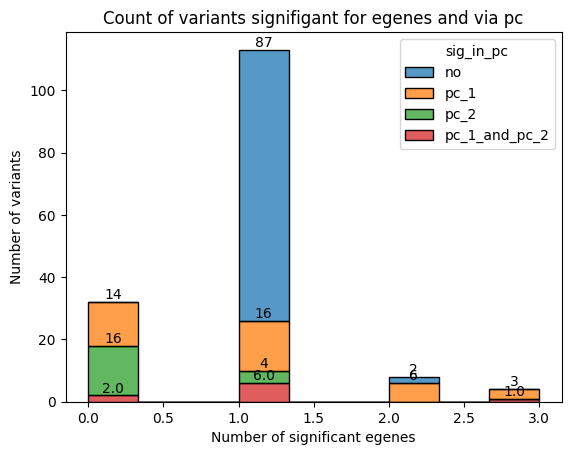

In [33]:
# how many variants are signifigant in multiple genes

# group by variants
e_group = e_indep_df.groupby('variant_id').agg({'phenotype_id':'count', 'sig_in_pc':'max'})

# add in pc_1 only variants
pc_1_vars = pc_indep_df[pc_indep_df['n_sig_egenes_match']==0]['variant_id'].unique()
pc_1_group = pd.DataFrame(data={'phenotype_id':[0]*len(pc_1_vars), 'sig_in_pc':[1]*len(pc_1_vars)}, index=pd.Index(pc_1_vars, name='variant_id'))

# add in pc_2 vars
pc2_indep_df['n_sig_egenes_match'] = pc2_indep_df.apply(get_matching_egenes, axis=1)
pc_2_vars = pc2_indep_df[pc2_indep_df['n_sig_egenes_match']==0]['variant_id'].unique()
pc_2_group = pd.DataFrame(data={'phenotype_id':[0]*len(pc_2_vars), 'sig_in_pc':[2]*len(pc_2_vars)}, index=pd.Index(pc_2_vars, name='variant_id'))

#conbine
pc_group = pd.concat([pc_1_group, pc_2_group]).groupby(['variant_id']).agg({'phenotype_id':'sum', 'sig_in_pc':'sum'})
full_group = pd.concat([e_group, pc_group])

# turn labels into words
def map_sig_pc(v):
    if v == 0:
        return 'no'
    elif v == 1:
        return 'pc_1'
    elif v == 2:
        return 'pc_2'
    else:
        return 'pc_1_and_pc_2'
full_group['sig_in_pc'] = full_group['sig_in_pc'].map(map_sig_pc)


# plot
y=sns.histplot(full_group, x='phenotype_id', hue='sig_in_pc', multiple='stack', hue_order=['no', 'pc_1', 'pc_2', 'pc_1_and_pc_2'])
for i in range(len(y.containers)):
    labels = [str(v) if v else '' for v in y.containers[i].datavalues]
    y.bar_label(y.containers[i], labels=labels)
plt.title('Count of variants signifigant for egenes and via pc')
plt.xlabel('Number of significant egenes')
plt.ylabel('Number of variants')
plt.show()

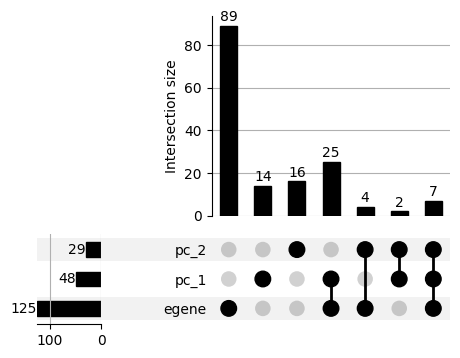

In [34]:
# upset without egene breakdowns
indep_upset = from_memberships(
    [['pc_1'],
     ['egene'],
     ['pc_1', 'egene'],
     ['pc_2'],
     ['pc_1', 'pc_2'],
     ['pc_2', 'egene'],
     ['pc_1', 'pc_2', 'egene']
     ],
     data=[sum((full_group['phenotype_id']==0)&(full_group['sig_in_pc']=='pc_1')),
           sum((full_group['phenotype_id']!=0)&(full_group['sig_in_pc']=='no')),  
           sum((full_group['phenotype_id']!=0)&(full_group['sig_in_pc']=='pc_1')),
           sum((full_group['phenotype_id']==0)&(full_group['sig_in_pc']=='pc_2')),
           sum((full_group['phenotype_id']==0)&(full_group['sig_in_pc']=='pc_1_and_pc_2')),
           sum((full_group['phenotype_id']!=0)&(full_group['sig_in_pc']=='pc_2')),
           sum((full_group['phenotype_id']!=0)&(full_group['sig_in_pc']=='pc_1_and_pc_2')),
          ]
)


plot(indep_upset,show_counts=True)
plt.show()

Text(0.5, 1.0, 'Count of cluster variants signifigant for multiple egenes')

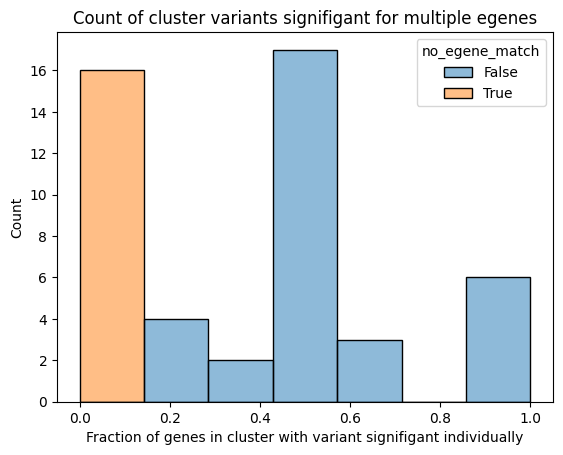

In [20]:
# for those that are in both a cluster and an egene, what fraction of the egenes in the cluster are covered?
# not really sold this plot is helpful 

pc_indep_df['frac_egenes'] = pc_indep_df['n_sig_egenes_match']/pc_indep_df['n_genes_cluster']
pc_indep_df['no_egene_match'] = pc_indep_df['n_sig_egenes_match'] == 0
sns.histplot(data = pc_indep_df, x='frac_egenes', hue='no_egene_match')
plt.xlabel('Fraction of genes in cluster with variant signifigant individually')
plt.title('Count of cluster variants signifigant for multiple egenes')


<Axes: xlabel='pval_beta', ylabel='pval_true_df'>

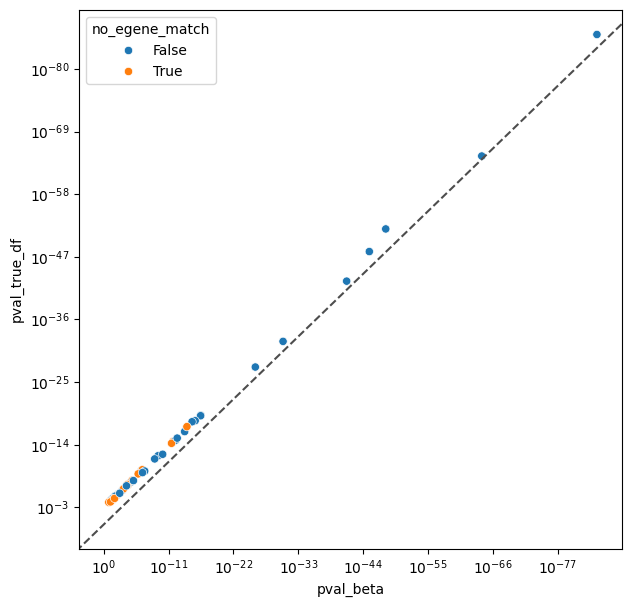

In [21]:
# whats different about the ones that are only pc and not single gene? higher p values? 
f, ax = plt.subplots(figsize=(7, 7))
ax.axline((1, 1), slope=1, ls="--", c=".3")

ax.set(yscale="log", xscale="log")
ax.invert_xaxis()
ax.invert_yaxis()
sns.scatterplot(data = pc_indep_df, x='pval_beta', y='pval_true_df', hue='no_egene_match', ax=ax)

### susie - any overlap

In [22]:
pc_susie_df[pc_susie_df['phenotype_id']=='ENSG00000142156.14_ENSG00000142173.14_pc1']

,Unnamed: 0,phenotype_id,variant_id,pip,af,cs_id
258,258,ENSG00000142156.14_ENSG00000142173.14_pc1,chr21_46065823_C_CAGA_b38,0.997253,0.674627,2


In [23]:
# make a df with one row per credible set
pc_cs_df = pc_susie_df.groupby(['phenotype_id', 'cs_id']).agg({'pip':list, 'variant_id': list})
pc_cs_df = pc_cs_df.reset_index()
pc_cs_df['cluster_id'] = pc_cs_df['phenotype_id'].str[:-4]

pc2_cs_df = pc2_susie_df.groupby(['phenotype_id', 'cs_id']).agg({'pip':list, 'variant_id': list})
pc2_cs_df = pc2_cs_df.reset_index()
pc2_cs_df['cluster_id'] = pc2_cs_df['phenotype_id'].str[:-4]


e_cs_df = e_susie_df.groupby(['phenotype_id', 'cs_id']).agg({'pip':list, 'variant_id': list})
e_cs_df = e_cs_df.reset_index()

In [24]:
# number of cluster credible sets where the a variant matches a variant in the credible set for 1+ 
# of the individual genes in the cluster 
def get_matching_ecs_pc(row):
    # just for egenes in the cluster
    gene_ids = row['phenotype_id'].split('_')
    ecs_cluster = e_cs_df[e_cs_df['phenotype_id'].isin(gene_ids)]
    return get_matching_ecs(row, ecs_cluster)

def get_matching_ecs_e(row):
    # for any other gene
    return get_matching_ecs(row, e_cs_df)

def get_matching_ecs(row, ecs_cluster):
    matching_filter = [len(set(x)&set(row['variant_id']))>0 for x in ecs_cluster['variant_id']]
    return len(ecs_cluster[matching_filter]['phenotype_id'].unique())

In [25]:
# check if in other pc df
def get_matching_pc2cs(row):
    pccs_cluster = pc2_cs_df[pc2_cs_df['cluster_id'] == row['cluster_id']]
    matching_filter = [len(set(x)&set(row['variant_id']))>0 for x in pccs_cluster['variant_id']]
    # false if no match, true otherwise
    if sum(matching_filter)>0:
        return 'pc_1_and_pc_2'
    else:
        return 'pc_1'
def get_matching_pc1cs(row):
    pccs_cluster = pc_cs_df[pc_cs_df['cluster_id'] == row['cluster_id']]
    matching_filter = [len(set(x)&set(row['variant_id']))>0 for x in pccs_cluster['variant_id']]
    # false if no match, true otherwise
    if sum(matching_filter)>0:
        return 'pc_1_and_pc_2'
    else:
        return 'pc_2'

In [26]:
# turn into group - index is phenotype_id/csidx, columns for number of egenes and which pcs sig

pc_cs_df['n_match_egene'] = pc_cs_df.apply(get_matching_ecs_pc, axis=1)
pc2_cs_df['n_match_egene'] = pc2_cs_df.apply(get_matching_ecs_pc, axis=1)
e_cs_df['n_match_egene'] = e_cs_df.apply(get_matching_ecs_e, axis=1)

pc_cs_df['match_pc'] = pc_cs_df.apply(get_matching_pc2cs, axis=1)
pc2_cs_df['match_pc'] = pc2_cs_df.apply(get_matching_pc1cs, axis=1)

In [27]:
def in_pcs(row):
    idx1 = 0
    idx2 = 0
    for var_id in row['variant_id']:
        idx1 = idx1 + sum(pc_susie_df[pc_susie_df['phenotype_id'].str.contains(row.phenotype_id)]['variant_id'] == var_id) 
        idx2 = idx2 + sum(pc2_susie_df[pc2_susie_df['phenotype_id'].str.contains(row.phenotype_id)]['variant_id'] == var_id) 
    if idx1>0 and idx2>0:
        return 'pc_1_and_pc_2'
    elif idx1>0:
        return 'pc_1'
    elif idx2>0:
        return 'pc_2'
    else: 
        return 'no'

e_cs_df['match_pc'] = e_cs_df.apply(in_pcs, axis=1)

In [28]:
# add id
pc_cs_df['phen_cs_id'] = pc_cs_df['phenotype_id'].astype(str) + '_cs' + pc_cs_df['cs_id'].astype(str)
pc2_cs_df['phen_cs_id'] = pc2_cs_df['phenotype_id'].astype(str) + '_cs' + pc2_cs_df['cs_id'].astype(str)
e_cs_df['phen_cs_id'] = e_cs_df['phenotype_id'].astype(str) + '_cs' + e_cs_df['cs_id'].astype(str)

In [29]:
# concat all the pc1 not in egene
# concat all the pc2 not in egene or pc1
# concat all the egene not in pc

# egen var fist approach

# group = pd.concat([e_cs_df[['n_match_egene', 'match_pc', 'phen_cs_id']], 
                   pc_cs_df[pc_cs_df['n_match_egene']==0][['n_match_egene', 'match_pc', 'phen_cs_id']],
                   pc2_cs_df[(pc2_cs_df['n_match_egene']==0)&(pc2_cs_df['match_pc']=='pc_2')][['n_match_egene', 'match_pc', 'phen_cs_id']]])

    

In [30]:
# concat all the pc 2 not shared wtih pc1 to pc1
# concat all the egene not in pc

# cluster first approach (I think this makes more sense)

group = pd.concat([pc2_cs_df[pc2_cs_df['match_pc'] != 'pc_1_and_pc_2'][['n_match_egene', 'match_pc', 'phen_cs_id']], 
                      pc_cs_df[['n_match_egene', 'match_pc', 'phen_cs_id']], 
                      e_cs_df[e_cs_df['match_pc'] == 'no'][['n_match_egene', 'match_pc', 'phen_cs_id']]])

    

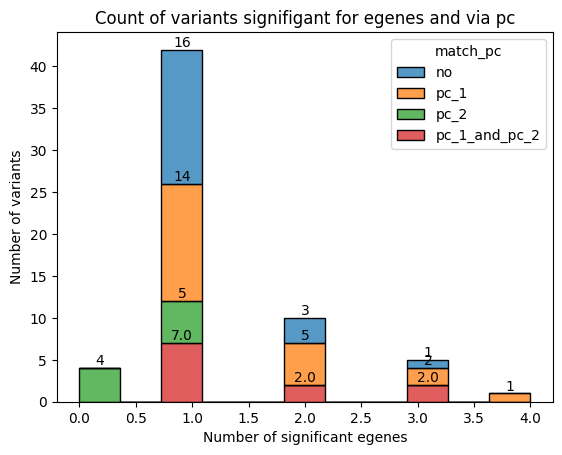

In [31]:

# plot
y=sns.histplot(group, x='n_match_egene', hue='match_pc', multiple='stack', hue_order=['no', 'pc_1', 'pc_2', 'pc_1_and_pc_2'])
for i in range(len(y.containers)):
    labels = [str(v) if v else '' for v in y.containers[i].datavalues]
    y.bar_label(y.containers[i], labels=labels)
plt.title('Count of variants signifigant for egenes and via pc')
plt.xlabel('Number of significant egenes')
plt.ylabel('Number of variants')
plt.show()

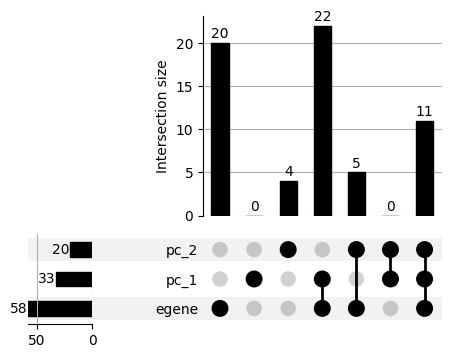

In [32]:
# upset without egene breakdowns
indep_upset = from_memberships(
    [['pc_1'],
     ['egene'],
     ['pc_1', 'egene'],
     ['pc_2'],
     ['pc_1', 'pc_2'],
     ['pc_2', 'egene'],
     ['pc_1', 'pc_2', 'egene']
     ],
     data=[sum((group['n_match_egene']==0)&(group['match_pc']=='pc_1')),
           sum((group['n_match_egene']!=0)&(group['match_pc']=='no')),  
           sum((group['n_match_egene']!=0)&(group['match_pc']=='pc_1')),
           sum((group['n_match_egene']==0)&(group['match_pc']=='pc_2')),
           sum((group['n_match_egene']==0)&(group['match_pc']=='pc_1_and_pc_2')),
           sum((group['n_match_egene']!=0)&(group['match_pc']=='pc_2')),
           sum((group['n_match_egene']!=0)&(group['match_pc']=='pc_1_and_pc_2')),
          ]
)


plot(indep_upset,show_counts=True)
plt.show()

#### colocalization

## Manhatten plot

In [146]:
# make a manhatten plot for one of the clusters

def manhatten_plot(e_pairs_df, e_indep_df, pc_pairs_dict, pc_indep_dict, cluster_id, sig_threshold=False):
    # get cluster info
    gene_ids = cluster_id.split('_')[:-1]

    f, ax = plt.subplots(figsize=(10, 7))
    ax.set(yscale="log")
    ax.invert_yaxis()


    # data for each of the eqtl gene nominal p values and tss locations
    i=1
    for gene_name, row in e_phenotype_pos_df.loc[gene_ids].iterrows():
        # scatter for the eqtl nominal p values
        sns.scatterplot(e_pairs_df.loc[e_pairs_df['phenotype_id'] == gene_name], x='variant_pos', 
                            y='pval_nominal', ax=ax, label=f'eqtl {gene_name} nominal p' if i == 1 else f'eqtl {gene_name}', 
                            color=sns.color_palette()[i], s=10)
        # lines for the gene tss
        ax.axvline(row['pos'], label='TSS' if i == 1 else '_no_legend_', color=sns.color_palette()[i], alpha=0.5)
        # independent signals
        sns.scatterplot(e_indep_df.loc[e_indep_df['phenotype_id'] == gene_name], 
                            x='variant_pos', y='pval_nominal', ax=ax, color=sns.color_palette()[i], 
                            marker='*', s=500, label='independent qtls' if i == 1 else '_no_legend_')
        # signifigance threshold
        if sig_threshold:
                x = e_cis_df.loc[e_cis_df['phenotype_id']== gene_name]['pval_nominal_threshold'].iloc[0]
                ax.axhline(x, color=sns.color_palette()[i], label='signifigance threshold' if i == 1 else '_no_legend_', ls='--')
        i=i+1
    ax.set_title(f'variant associations for {cluster_id}')

    # data for the cluster nominal p values for each pc
    
    for i in [1, 2]:
        pc_pairs_df = pc_pairs_dict[i]
        pc_indep_df = pc_indep_dict[i]
        sns.scatterplot(pc_pairs_df.loc[pc_pairs_df['cluster_id']== cluster_id], 
                        x='variant_pos', y='pval_nominal', ax=ax, color=sns.color_palette('Paired', 9)[2-i], 
                        label=f'PC_{i}', s=10)
        sns.scatterplot(pc_indep_df.loc[pc_indep_df['cluster_id']== cluster_id], 
                        x='variant_pos', y='pval_nominal', ax=ax, 
                        color=sns.color_palette('Paired', 9)[2-i], marker='*', s=700)

    if sig_threshold:
        # line for signifigance 
        x = pc_cis_dict[1].loc[pc_cis_dict[1]['cluster_id']== cluster_id]['pval_nominal_threshold'].iloc[0]
        ax.axhline(x, color=sns.color_palette()[0], ls='--')
    else:
        # plot just the highest threshold
        xs=[]
        for gene_name, row in e_phenotype_pos_df.loc[gene_ids].iterrows():
            xs.append(e_cis_df.loc[e_cis_df['phenotype_id']== gene_name]['pval_nominal_threshold'].iloc[0])
        ax.axhline(np.min(xs), color='k', ls='--', label='signifigance threshold')

    ax.legend()
    plt.show()

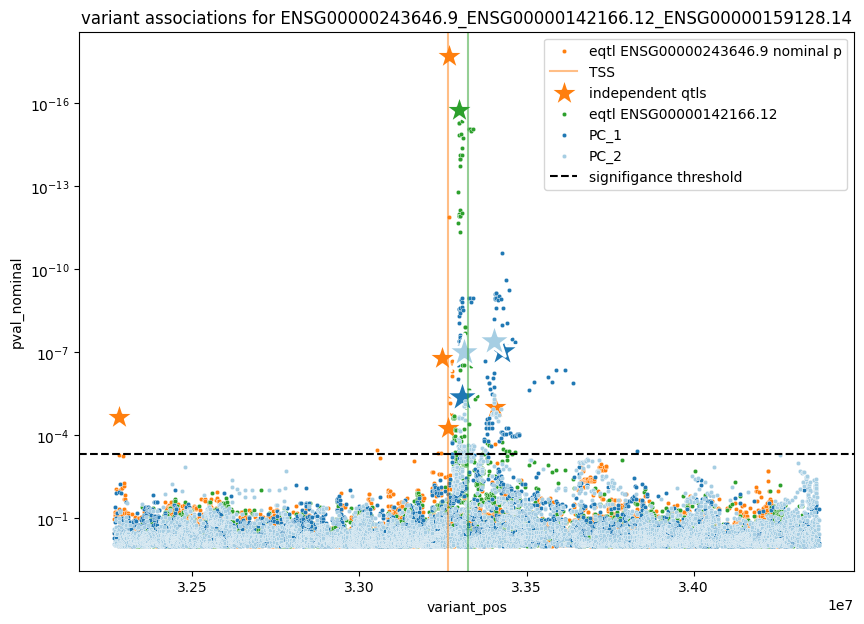

In [147]:
# test cluster
idx = 3
manhatten_plot(e_pairs_df, e_indep_df, pc_pairs_dict, pc_indep_dict, pc_phenotype_df.iloc[idx].name[:-4])

## Scatterplot

In [160]:
# instead of many-many as above, I want the nominal p value for each qtl in each cluster 
# compared to the minimum nominal p value for the genes in that cluster
# The end dataset will have 1 point for each row in the clusters df (148084)

# a df for each cluster that will then be combined
join_dfs=[]

for i in range(len(pc_pairs_dict[1]['cluster_id'].unique())):
    cluster_id = pc_pairs_dict[1]['cluster_id'].unique()[i]
    gene_ids = cluster_id.split('_')[:-1]

    # get the min for the eqtls in this cluster
    tmp_e = e_pairs_df.loc[e_pairs_df['phenotype_id'].isin(gene_ids)].groupby('variant_id').min()
    # join to the cluster
    cluster_join_df = pc_pairs_dict[1][pc_pairs_dict[1]['cluster_id']==cluster_id].set_index('variant_id').join(tmp_e, rsuffix='_e')
    cluster_join_df = pc_pairs_dict[2][pc_pairs_dict[2]['cluster_id']==cluster_id].set_index('variant_id').join(cluster_join_df, lsuffix='_pc2', rsuffix='_pc1')

    join_dfs.append(cluster_join_df)        

join_df_control = pd.concat(join_dfs)                                                                                                                                                        

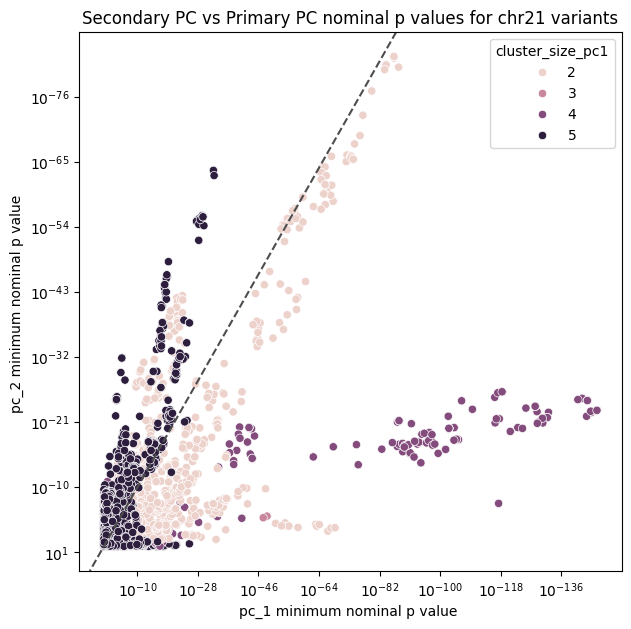

In [179]:
# plot pc1 vs pc2 nominal p values

f, ax = plt.subplots(figsize=(7, 7))
ax.axline((1, 1), slope=1, ls="--", c=".3")

ax.set(yscale='log', xscale='log')
ax.invert_yaxis()
ax.invert_xaxis()


sns.scatterplot(data=join_df_control, x ='pval_nominal_pc1', y='pval_nominal_pc2', hue='cluster_size_pc1', ax=ax)
ax.set_xlabel('pc_1 minimum nominal p value ')
ax.set_ylabel('pc_2 minimum nominal p value ')
ax.set_title('Secondary PC vs Primary PC nominal p values for chr21 variants')

plt.show()


ValueError: cannot reindex on an axis with duplicate labels

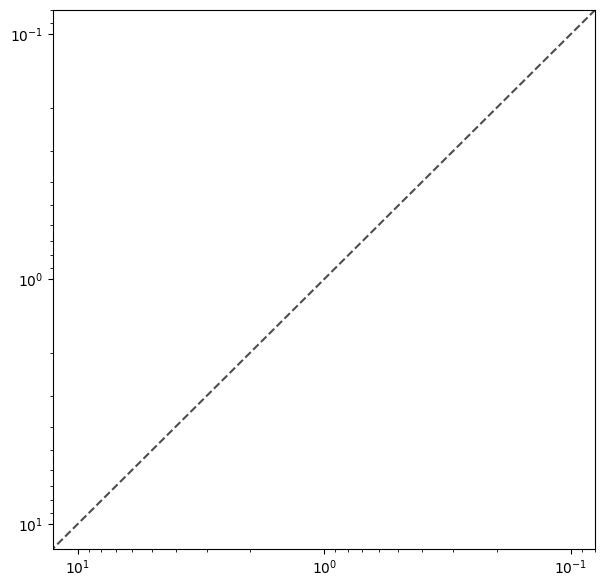

In [183]:
# instead of min vs min, do 1 vs min
# so each point has a paired value for every time it appears in the clusters df

f, ax = plt.subplots(figsize=(7, 7))
ax.axline((1, 1), slope=1, ls="--", c=".3")

ax.set(yscale='log', xscale='log')
ax.invert_yaxis()
ax.invert_xaxis()


sns.scatterplot(data=join_df_control, x ='pval_nominal_e', y='pval_nominal_pc1', hue='cluster_size_pc1', ax=ax)
ax.set_ylabel('pc_2 minimum nominal p value ')
ax.set_xlabel('expression minimum nominal p value')
ax.set_title('Secondary PC vs expression many-many nominal p values for chr21 variants')

plt.show()


ValueError: cannot reindex on an axis with duplicate labels

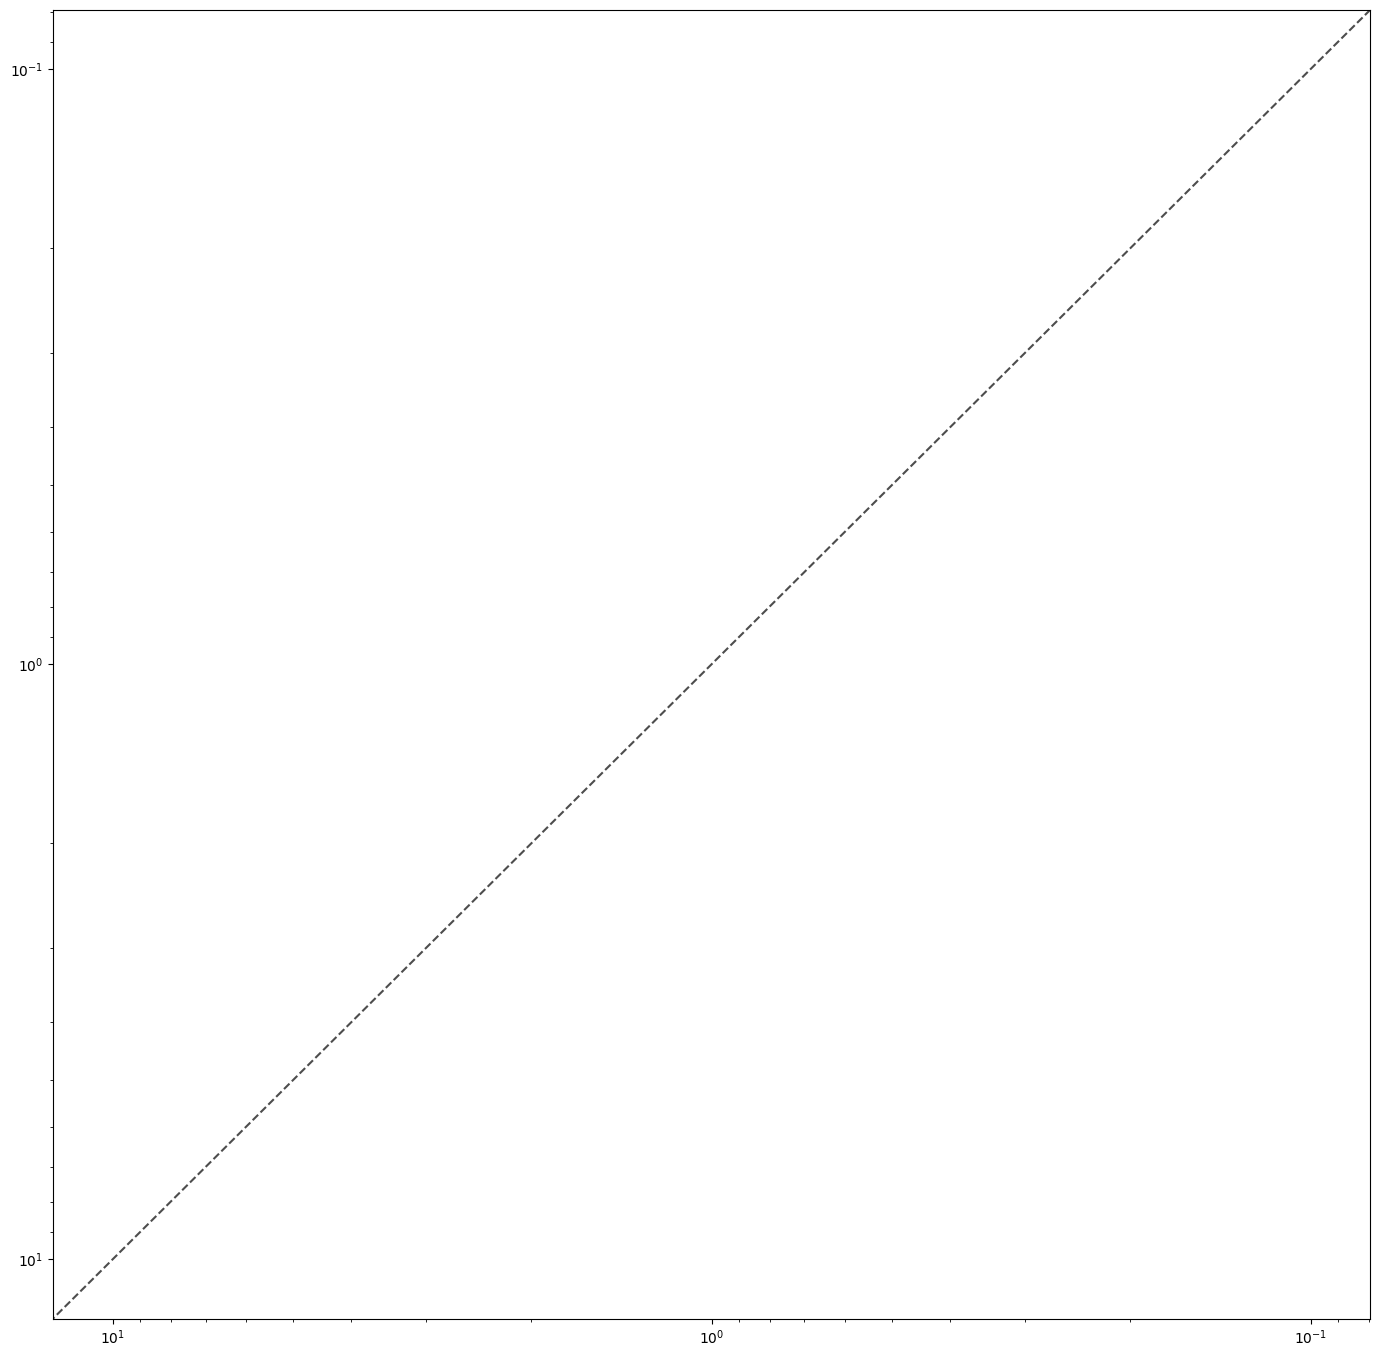

In [172]:
# instead of min vs min, do all vs all
# so each point has a paired value for every time it appears in the expression df, no just the clusters df

f, ax = plt.subplots(figsize=(17, 17))
ax.axline((1, 1), slope=1, ls="--", c=".3")

ax.set(yscale='log', xscale='log')
ax.invert_yaxis()
ax.invert_xaxis()


sns.scatterplot(data=join_df_control, x ='pval_nominal_e', y='pval_nominal_pc2', hue='phenotype_id_pc2', ax=ax)
ax.set_ylabel('pc_2 minimum nominal p value ')
ax.set_xlabel('expression minimum nominal p value')
ax.set_title('Secondary PC vs expression many-many nominal p values for chr21 variants')

plt.show()


Text(0.5, 1.0, 'Primary PC vs expression minimum nominal p values for chr21 variants')

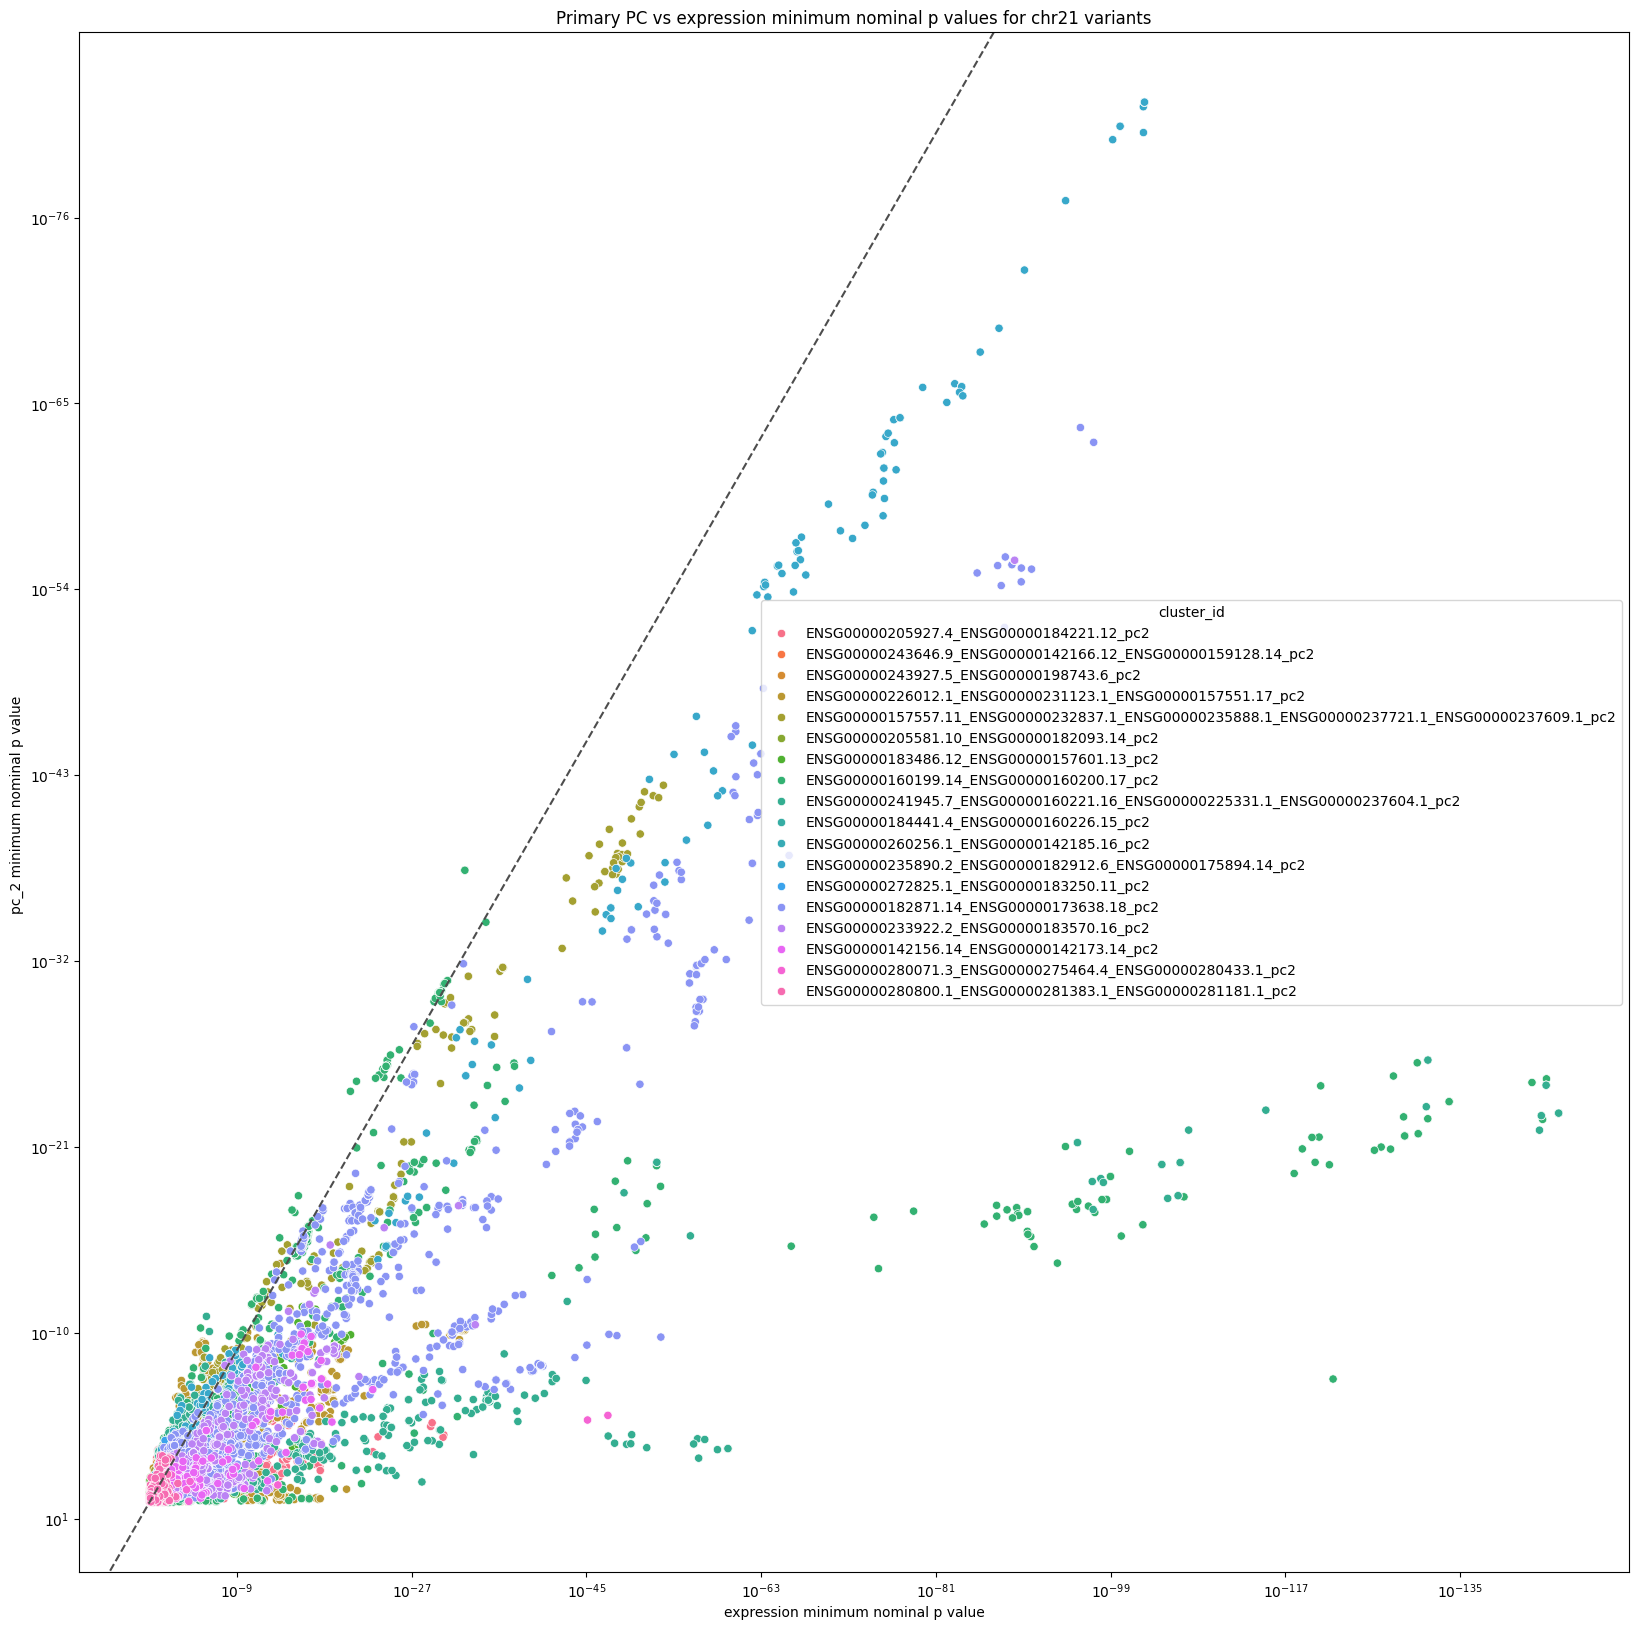

In [73]:
# minimum p value for each variant
e_minp_df = e_pairs_df.groupby('variant_id').min('pval_nominal')
pc_minp_df = pc_pairs_df.reset_index().groupby('variant_id').min('pval_nominal')
e_minp_df['cluster_pval_nominal'] = pc_minp_df.reindex(e_minp_df.index)['pval_nominal']

# number of times that snp appeared in eqtl or pc analysis
e_minp_df['num_eqtl'] = e_pairs_df.groupby('variant_id').size()
e_minp_df['num_pcqtl'] = pc_pairs_df.groupby('variant_id').size().reindex(e_minp_df.index)
# cluster size
e_minp_df['cluster_size'] = pc_minp_df.reindex(e_minp_df.index)['cluster_size']
e_minp_df['cluster_id'] = pc_pairs_df.iloc[pc_minp_df.reindex(e_minp_df.index)['index']]['phenotype_id'].values

# generally agreement between scatters in across all clusters

f, ax = plt.subplots(figsize=(20, 20))
ax.axline((1, 1), slope=1, ls="--", c=".3")

ax.set(yscale='log', xscale='log')
ax.invert_yaxis()
ax.invert_xaxis()

sns.scatterplot(data=e_minp_df, x ='pval_nominal', y='cluster_pval_nominal', hue='cluster_id', ax=ax)
ax.set_ylabel('pc_2 minimum nominal p value ')
ax.set_xlabel('expression minimum nominal p value')
ax.set_title('Primary PC vs expression minimum nominal p values for chr21 variants')